In [151]:
import os
import gymnasium as gym
import ale_py
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import torch.nn.functional as F
from typing import Optional
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [152]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [153]:
ENV = "PongDeterministic-v4"
BATCH_SIZE = 64
GAMMA = 0.97
EPSILON_START = 1.0
EPSILON_END = 0.05
EPSILON_DECAY = 0.99
TARGET_UPDATE = 1000
MAX_MEMORY_SIZE = 25000
MIN_MEMORY_SIZE = 24000
LEARNING_RATE = 0.00025
CHECKPOINT_PATH = "./checkpoints"

In [154]:
class DualDQN(nn.Module):
    def __init__(self, action_space: int):
        super(DualDQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.advantage_stream = nn.Linear(1536, 128)
        self.advantage_stream2 = nn.Linear(128, action_space)
        self.value_stream = nn.Linear(1536, 128)
        self.value_stream2 = nn.Linear(128, 1)

    def forward(self, x: torch.tensor) -> torch.tensor:
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)

        value = self.value_stream2(F.leaky_relu(self.value_stream(x)))
        advantage = self.advantage_stream2(F.leaky_relu(self.advantage_stream(x)))
        q_values = value + (advantage - advantage.mean())

        return q_values

In [155]:
def preprocess_observation(image: np.ndarray) -> torch.tensor:
    target_h = 80
    target_w = 64
    crop_dim = [20, image.shape[0], 0, image.shape[1]]
    frame = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    frame = frame[crop_dim[0] : crop_dim[1], crop_dim[2] : crop_dim[3]]
    frame = cv2.resize(frame, (target_w, target_h))
    frame = frame.reshape(target_w, target_h) / 255
    return torch.tensor(frame, dtype=torch.float32).to(device=device)


In [156]:
def optimize_model(
    memory: deque,
    policy_net: DualDQN,
    target_net: DualDQN,
    optimizer: torch.optim.Optimizer,
) -> float:
    if len(memory) < MIN_MEMORY_SIZE:
        return

    transitions = random.sample(memory, BATCH_SIZE)
    batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(
        *transitions
    )

    batch_state = torch.cat(batch_state).unflatten(0, (BATCH_SIZE, -1)).to(device)
    batch_action = torch.tensor(batch_action).to(device)
    batch_reward = torch.tensor(batch_reward).to(device)
    batch_next_state = (
        torch.cat(batch_next_state).unflatten(0, (BATCH_SIZE, -1)).to(device)
    )
    batch_done = torch.tensor(batch_done, dtype=torch.bool).to(device)

    current_q_values = (
        policy_net(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
    )
    next_q_values = policy_net(batch_next_state)
    next_target_q_values = (
        target_net(batch_next_state)
        .gather(1, next_q_values.max(1)[1].unsqueeze(1))
        .squeeze(1)
    )
    expected_q_values = batch_reward + (GAMMA * next_target_q_values) * (~batch_done)

    loss = nn.SmoothL1Loss()(current_q_values, expected_q_values.detach())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [157]:
def select_action(
    state: torch.tensor, epsilon: float, action_space: int, policy_net: DualDQN
) -> int:
    if random.random() < epsilon:
        return random.randrange(action_space)
    else:
        with torch.no_grad():
            state = state.unsqueeze(0)
            return torch.argmax(policy_net(state)).item()

In [158]:
def get_latest_version(path: str = CHECKPOINT_PATH) -> Optional[str]:
    versions = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    return max(versions) if versions else None


def save_model_and_hyperparameter(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    epsilon: float,
    episode: int,
    path: str = CHECKPOINT_PATH,
    version: Optional[str] = None,
) -> str:
    if version is None:
        version = datetime.now().strftime("pong_dqn_%Y-%m-%d_%H-%M-%S")
        print(f"Version: {version}")
    version_path = os.path.join(path, version)
    os.makedirs(version_path, exist_ok=True)

    model_path = os.path.join(version_path, f"pong-policy-net-{episode}.pt")
    optimizer_path = os.path.join(version_path, f"pong-optimizer-{episode}.pt")
    epsilon_path = os.path.join(version_path, f"epsilon-{episode}.json")

    torch.save(model.state_dict(), model_path)
    torch.save(optimizer.state_dict(), optimizer_path)
    with open(epsilon_path, "w") as f:
        f.write(json.dumps({"epsilon": epsilon}))
    return version


def load_model_and_hyperparameter(
    model: nn.Module,
    optimizer: Optional[torch.optim.Optimizer],
    epsilon: Optional[float],
    episode: int,
    path: str = CHECKPOINT_PATH,
    version: Optional[str] = None,
) -> tuple[nn.Module, torch.optim.Optimizer, float, Optional[str]]:
    if version is None:
        return model, optimizer, epsilon, None
    version_path = os.path.join(path, version)

    model_path = os.path.join(version_path, f"pong-policy-net-{episode}.pt")
    optimizer_path = os.path.join(version_path, f"pong-optimizer-{episode}.pt")
    epsilon_path = os.path.join(version_path, f"epsilon-{episode}.json")

    if any([not os.path.exists(p) for p in [model_path, optimizer_path, epsilon_path]]):
        return model, optimizer, epsilon

    model.load_state_dict(torch.load(model_path))
    if optimizer is not None:
        optimizer.load_state_dict(torch.load(optimizer_path))
    if epsilon is not None:
        with open(epsilon_path, "r") as f:
            epsilon = json.loads(f.read())["epsilon"]
    return model, optimizer, epsilon, version

In [159]:
def run_train(
    env,
    memory: deque,
    policy_net: DualDQN,
    target_net: DualDQN,
    optimizer: torch.optim.Optimizer,
    epsilon: float,
    version=None,
):
    num_episodes = 1000
    epsilon = epsilon
    version = f'pong_dqn_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'
    writer = SummaryWriter("runs/" + version)
    global_step = 0
    for episode in tqdm(range(num_episodes), desc="Training Episodes"):
        obs, _ = env.reset()
        state = preprocess_observation(obs)
        state = torch.stack([state] * 4, axis=0)

        total_reward = 0
        done = False
        steps = 0
        total_loss = 0

        while not done:
            action = select_action(
                state=state,
                epsilon=epsilon,
                action_space=env.action_space.n,
                policy_net=policy_net,
            )
            next_obs, reward, done, truncated, _ = env.step(action)
            done = done or truncated
            total_reward += reward
            next_state = preprocess_observation(next_obs)
            next_state = torch.stack((next_state, state[0], state[1], state[2]))

            memory.append((state, action, reward, next_state, done))
            state = next_state
            steps += 1
            global_step += 1

            loss = optimize_model(
                memory=memory,
                policy_net=policy_net,
                target_net=target_net,
                optimizer=optimizer,
            )
            if loss is not None:
                total_loss += loss

            if steps % TARGET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())

            if global_step % 1000 == 0:
                if epsilon > EPSILON_END:
                    epsilon *= EPSILON_DECAY
        if episode % 10 == 0:
            save_model_and_hyperparameter(
                model=policy_net,
                optimizer=optimizer,
                epsilon=epsilon,
                episode=episode,
                version=version,
            )
        writer.add_scalar("Total Loss", total_loss, episode)
        writer.add_scalar("Steps", steps, episode)
        writer.add_scalar("Epsilon", epsilon, episode)
        writer.add_scalar("Total Reward", total_reward, episode)
    writer.close()

## Training

### Gym setup

In [140]:
gym.register_envs(ale_py)
env = gym.make(ENV)
memory = deque(maxlen=MAX_MEMORY_SIZE)
epsilon = EPSILON_START

### Initialize policy and target network from scratch

In [141]:
policy_net = DualDQN(env.action_space.n).to(device)
target_net = DualDQN(env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)

### Load model and optimizer from checkpoint

In [ ]:
episode = 0
version = None
# version = get_latest_version()
policy_net, optimizer, epsilon, version = load_model_and_hyperparameter(
    model=policy_net,
    optimizer=optimizer,
    epsilon=epsilon,
    episode=episode,
    version=None,
)

In [ ]:
run_train(
    env=env,
    memory=memory,
    policy_net=policy_net,
    target_net=target_net,
    optimizer=optimizer,
    epsilon=epsilon,
    version=version,
)

In [ ]:
# env.reset()
# obs = env.step(0)
# obs = preprocess_observation(obs[0])

## Metrics Results

In [ ]:
metrics_result_path = "metrics_results/"
metrics = ["total_reward", "steps", "epsilon", "total_loss"]
metrics_result_path = [os.path.join(metrics_result_path, f"{m}.json") for m in metrics]
results = {}
for m, path in zip(metrics, metrics_result_path):
    with open(path, "r") as f:
        results[m] = json.loads(f.read())
# The data structure is as follows:
# results["metric"] = [[timestamp, value, episode], ...]

In [146]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode="valid")


def plot_with_smooth_line(
    ax, x, y, title, hline_type="max", window_size=30, show_average=True
):
    if show_average:
        # Calculate the moving average
        y_smooth = moving_average(y, window_size)
        x_smooth = x[: len(y_smooth)]  # Adjust x to match the length of y_smooth

        # Find the min or max value of the smooth average
        if hline_type == "max":
            hline_value = np.max(y_smooth)
        elif hline_type == "min":
            hline_value = np.min(y_smooth)
        else:
            raise ValueError("hline_type must be either 'min' or 'max'")

    # Determine legend position based on the last value of y
    legend_position = "upper right" if y[-1] < np.mean(y) else "lower right"

    # Set the title and labels with LaTeX-like fonts
    ax.set_title(title, fontsize=16, weight="bold", family="serif")
    ax.set_xlabel("Episode", fontsize=14, family="serif")
    ax.set_ylabel(title, fontsize=14, family="serif")

    # Plot the original data
    ax.plot(x, y, color="black", linewidth=1.5, label=title)

    if show_average:
        # Plot the smooth average line
        ax.plot(x_smooth, y_smooth, color="red", linewidth=2, label=f"Average {title}")

        # Add a horizontal line at the min or max value of the smooth average
        ax.axhline(hline_value, color="gray", linestyle="--", linewidth=1.5)

        # Add the min or max value text on the left side
        ax.text(
            x[0],
            hline_value,
            f"{hline_value:.2f}",
            va="center",
            ha="right",
            fontsize=12,
            family="serif",
            color="gray",
        )
    else:
        if hline_type == "max":
            hline_value = np.max(y)
        elif hline_type == "min":
            hline_value = np.min(y)
        ax.axhline(hline_value, color="gray", linestyle="--", linewidth=1.5)
        ax.text(
            x[0],
            hline_value,
            f"{hline_value:.2f}",
            va="center",
            ha="right",
            fontsize=12,
            family="serif",
            color="gray",
        )

    # Customize the grid
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray")

    # Customize the ticks
    ax.tick_params(axis="both", which="major", labelsize=12)
    ax.tick_params(axis="both", which="minor", labelsize=10)

    # Set the background color to white
    ax.set_facecolor("white")

    # Remove the top and right spines for a cleaner look
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Customize the x and y axis ticks to use LaTeX-like fonts
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:.2f}"))

    # Set the tick labels to use LaTeX-like fonts
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(12)
        label.set_family("serif")

    # Add a legend with a box around it
    legend = ax.legend(
        loc=legend_position, fancybox=True, framealpha=1, edgecolor="black", fontsize=12
    )
    legend.get_frame().set_linewidth(1.5)  # Set the linewidth of the legend box
    legend.get_frame().set_facecolor("white")  # Set the face color of the legend box


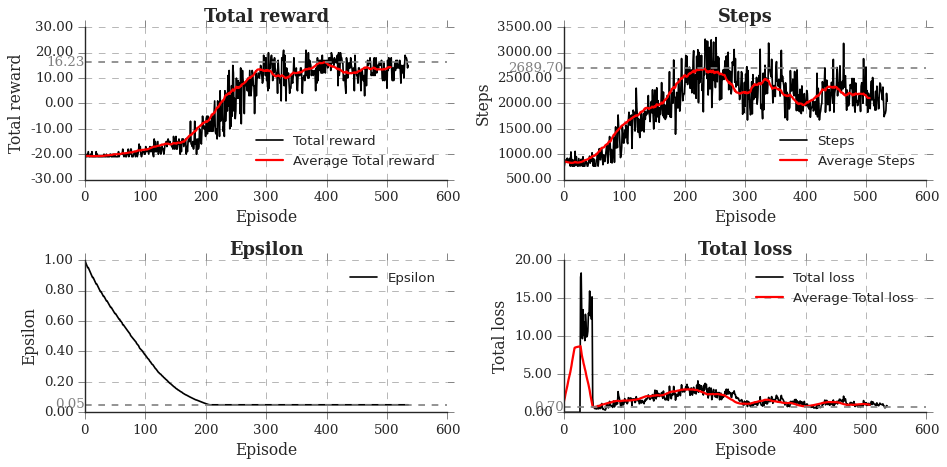

In [147]:
metric_max_min = {
    "total_reward": "max",
    "steps": "max",
    "epsilon": "min",
    "total_loss": "min",
}
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
for ax, metric in zip(axs.flatten(), metrics):
    x = [r[1] for r in results[metric]]
    y = [r[2] for r in results[metric]]
    title = " ".join(metric.split("_")).capitalize()
    show_average = metric != "epsilon"
    plot_with_smooth_line(
        ax, x, y, title, hline_type=metric_max_min[metric], show_average=show_average
    )

plt.tight_layout()
plt.show()

## Generate a Video of Agent playing Pong

In [ ]:
gym.register_envs(ale_py)
env = gym.make(ENV)
policy_net = DualDQN(env.action_space.n).to(device)
policy_net, _, _, _ = load_model_and_hyperparameter(
    model=policy_net, optimizer=None, epsilon=None, episode=530, version="best"
)
policy_net.eval()
obs, _ = env.reset()
state = preprocess_observation(obs)
state = torch.stack([state] * 4, axis=0)
total_reward = 0
done = False
frames = []
while not done:
    action = select_action(
        state=state,
        epsilon=0,
        action_space=env.action_space.n,
        policy_net=policy_net,
    )
    next_obs, reward, done, truncated, _ = env.step(action)
    total_reward += reward
    next_state = preprocess_observation(next_obs)
    next_state = torch.stack((next_state, state[0], state[1], state[2]))
    state = next_state
    frames.append(next_obs)

### Save the frames as video

In [ ]:
height, width, _ = frames[0].shape
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video = cv2.VideoWriter("videos/pong_dqn.mp4", fourcc, 60, (width, height))
for frame in frames:
    video.write(frame)
video.release()

In [177]:
import imageio
imageio.mimsave("videos/pong_dqn.gif", frames[:80])